In [227]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 27 11:19:07 2020

@author: Max J. de Bock
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
from scipy.interpolate import make_interp_spline, BSpline
import numpy.polynomial.polynomial as poly
import statistics as stat
from scipy.signal import find_peaks
from scipy.stats import norm, jarque_bera
from scipy.fft import fft, ifft
from sympy.integrals.transforms import laplace_transform
from scipy.fftpack import fftshift
import scipy as sc
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

# Download data sets and create empty data frames (just run it)

In [228]:
df = pd.DataFrame({'Series': [np.nan], 'Epsilon': [np.nan], 'Sd': [np.nan]}).dropna()
def LoadData():
    SP = pd.read_csv('^GSPC.csv')
    Minute_data =  pd.read_csv('S&P minute data.csv')
    return SP, Minute_data
sp, minute_data = LoadData()
display(minute_data.iloc[:10])


C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,24

,Unnamed: 0,A,A.1,A.2,A.3,A.4,AAL,AAL.1,AAL.2,AAL.3,...,ZION,ZION.1,ZION.2,ZION.3,ZION.4,ZTS,ZTS.1,ZTS.2,ZTS.3,ZTS.4
0,NaN,open,high,low,close,volume,open,high,low,close,...,open,high,low,close,volume,open,high,low,close,volume
1,timestamp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-09-11 09:30:00,NaN,NaN,NaN,NaN,NaN,44.01,44.05,44.01,44.01,...,42.05,42.05,42.04,42.04,26933.0,NaN,NaN,NaN,NaN,NaN
3,2017-09-11 09:31:00,65.5,65.5,65.41,65.46,29852.0,44.01,44.25,44.0,44.25,...,42.06,42.54,42.01,42.24,39292.0,65.33,65.39,64.96,65.11,38144.0
4,2017-09-11 09:32:00,65.4604,65.66,65.4604,65.66,3435.0,44.25,44.32,44.22,44.27,...,42.12,42.48,42.09,42.48,9683.0,65.115,65.23,65.075,65.12,4390.0
5,2017-09-11 09:33:00,65.67,65.7,65.62,65.69,700.0,44.28,44.46,44.2504,44.34,...,42.49,42.49,42.18,42.2,7844.0,NaN,NaN,NaN,NaN,NaN
6,2017-09-11 09:34:00,65.69,65.88,65.68,65.88,2814.0,44.34,44.36,44.22,44.24,...,42.28,42.38,42.23,42.38,6472.0,65.12,65.18,64.97,64.97,5515.0
7,2017-09-11 09:35:00,65.81,65.9,65.77,65.83,1300.0,44.2429,44.26,44.1,44.17,...,42.42,42.47,42.42,42.47,1000.0,65.03,65.14,65.0,65.0,2100.0
8,2017-09-11 09:36:00,65.88,65.9,65.66,65.66,6986.0,44.1655,44.18,44.03,44.07,...,42.43,42.51,42.4,42.4,5835.0,65.065,65.31,65.065,65.145,5200.0
9,2017-09-11 09:37:00,65.73,65.77,65.65,65.76,2420.0,44.08,44.1301,44.06,44.065,...,42.35,42.38,42.28,42.31,32358.0,65.12,65.12,64.95,65.05,2502.0


# White noise 

In [4]:
def WhiteNoise(df,mean,sd):
    n = 100
    for i in range(n):
        Xt = np.random.normal(mean,sd)
        df = df.append({'Series': Xt}, ignore_index=True)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

# Qth-Order Moving Average:

In [5]:
def QthMovAve(df,mean,sd,order):
    weights = np.linspace(1,order,order)
    weights = weights/np.sum(weights)
    n = 1000
    for i in range(n):
        epsilon = np.random.normal(0,sd)
        Xt = mean
        if i != 0:
            for j in range(np.minimum(i,order-1)):    
                 Xt += weights[order-j-1]*df['Epsilon'].iloc[i-j-1]
        df = df.append({'Series': Xt, 'Epsilon': epsilon}, ignore_index=True)
    print(df)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

In [6]:
def SquaredErrorforCycleLength(A,length):
    A = np.array(A)
    var_list = np.zeros(length)
    n = len(A)
    for i in range(length):
        k = 0
        point_list = []
        while k*length <= n-1:
            point_list.append(A[k*length])
            k += 1
        var_list[i] = stat.variance(point_list)
    return stat.mean(var_list)

Thing that tries to find period of periodic function:

In [7]:
def CycleLength(A):
    A = np.array(A)
    SquaredErrors = np.zeros(int(len(A)*2/3))
    for length in range(1,int(len(A)*2/3)):
        SquaredErrors[length] = SquaredErrorforCycleLength(A, length)
    return SquaredErrors

# Qth-Order Auto-regressive:

In [8]:
def QthAR(df,sd,order):
    weights = np.linspace(1,order,order)
    weights = weights/np.sum(weights)
    n = 100
    for i in range(n):
        epsilon = np.random.normal(0,sd)
        Xt = epsilon
        if i != 0:
            for j in range(np.minimum(i,order)):
                Xt += weights[order-j-1]*df['Series'].iloc[i-j-1]
        df = df.append({'Series': Xt}, ignore_index=True)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

# Qth-order Auto-regressive conditional heteroskedasticity (ARCH):

In [9]:
def QArch(df,a,order,n):
    #Choosing the weights of the model (assuming weakly-stationary covariance)
    weights = np.linspace(1,order,order)
    weights = (200)**(weights/order)
    weights = weights/np.sum(weights)
    for i in range(n):
        #This is that first term constant
        sd = a
        for j in range(np.minimum(i,order+1)):
            #Summing the products of the weights and squares of previous datapoints
            sd += weights[order-j-1]*df['Series'].iloc[i-j-1]*df['Series'].iloc[i-j-1]
        #Generating next datapoint
        Xt = np.random.normal(0,sd)
        df = df.append({'Series': Xt, 'Sd': sd}, ignore_index=True)
    #Just formatting
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('ARCH(%d)' % order)
    lin = np.linspace(1,n,n)
    ax1.bar(lin,df['Series'])
    ax2.bar(lin,df['Sd'])
    #Getting an approximating poly through it uses Gaussian quadrature,
    #so it is going to be exact up to n/2. This is why I picked n/10.
    #This is really just a randomly chosen number, but line looks 'eye-ball' representative for smoothness = 10 if n = 1000.
    #EDIT: The smoothness of the line will be will change the scale that the red line represents, meaning the period of 
    #the line will be very clearly altered by this!!!
    smoothness = 10
    degree = int(np.ceil(n/smoothness))
    xnew = np.linspace(1,n, n*10) 
    coefs = poly.polyfit(lin, df['Sd'], degree)
    ffit = poly.polyval(xnew, coefs)
    plt.plot(xnew, ffit, 'r')
    # #More formatting
    low = min(df['Sd'])
    high = max(df['Sd'])
    plt.ylim([low,high])
    ax3 = ax2.twinx()
    cycle_length = CycleLength(ffit[1::10])
    
    l = len(cycle_length)
    ax3.plot(np.linspace(1,l,l),cycle_length)
    #perform Fourier transform on graph (cutting of edges due to weird behaviour)
    slicing = 50
    ax3.plot(np.linspace(1+int(slicing/10),n-int(slicing/10),n*10-2*slicing),abs(fft(ffit[slicing:len(ffit)-slicing])))
    plt.ylim([0,0.2])
    fig.tight_layout()
    plt.show()
    
    
    return find_peaks(cycle_length, \
                      #threshold = (max(cycle_length)-min(cycle_length))/40),\
                      width = 10),\
           #ChangePlot(df['Series'])

C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


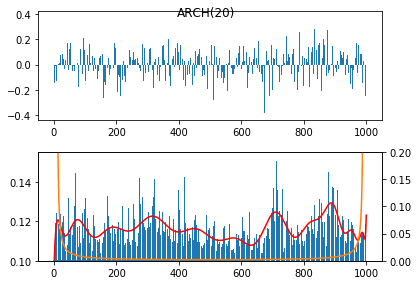

((array([177, 222, 296, 354, 444, 500, 573], dtype=int64),
  {'prominences': array([7.52172044e-05, 6.59794478e-05, 8.37638019e-05, 1.05078984e-04,
          1.87011125e-04, 2.70794350e-05, 1.41545112e-05]),
   'left_bases': array([  0, 195,   0,   0,   0, 498, 530], dtype=int64),
   'right_bases': array([195, 249, 332, 388, 630, 630, 630], dtype=int64),
   'widths': array([10.79546442, 13.01479711, 14.25246872, 34.33116788, 31.39476385,
          14.06177665, 38.31142862]),
   'width_heights': array([7.29203875e-05, 7.68872153e-05, 1.23441933e-04, 1.16034135e-04,
          1.25531160e-04, 6.08059957e-05, 6.16658742e-05]),
   'left_ips': array([171.11186135, 214.23230197, 288.38474758, 333.77432475,
          424.2958879 , 498.96757192, 552.16327891]),
   'right_ips': array([181.90732577, 227.24709907, 302.63721631, 368.10549263,
          455.69065175, 513.02934857, 590.47470753])}),)

In [21]:
#To get decent compromise between data and run-time I went for QArch(df,0.1,20,1000)
QArch(df,0.1,20,1000)

# Daily-changes hist, fitting Gauss distr and JB-test:

In [301]:
def BarReturnsPlot(A):
    rol = 20
    if len(A.shape) == 2:
        Returns = A['Close']-A['Open']
    else:
        Returns = A    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    l = len(Returns)
    lin = np.linspace(1,l,l)
    
    var = (Returns.rolling(rol).std(ddof=0))**2
    
    ax1.bar(lin,Returns)
    ax2.bar(lin,var)

    smoothness = 30
    degree = int(np.ceil(l/smoothness))
    xnew = np.linspace(1,l, l*smoothness) 
    coefs = poly.polyfit(lin[rol:], var[rol:], degree)
    ffit = poly.polyval(xnew, coefs)
    plt.plot(xnew, ffit, 'r')
    # #More formatting
    low = min(var[rol:])
    high = max(var[rol:])
    plt.ylim([low,high])
    
    plt.bar(lin,Returns)
    
    plt.bar(lin,var)
    plt.show()
    return var,jarque_bera(Returns)
    

In [2]:
a = [0,1,2,3,4,5,6,7,8,9,10]
print(a[::2])

[0, 2, 4, 6, 8, 10]


C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


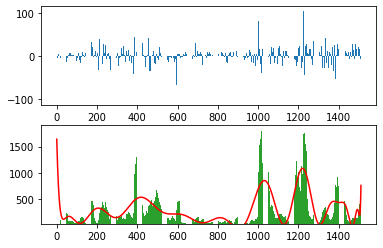

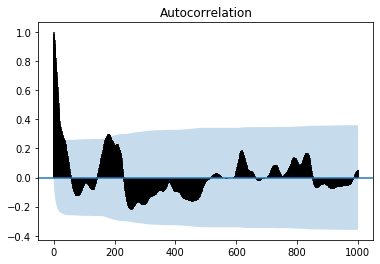

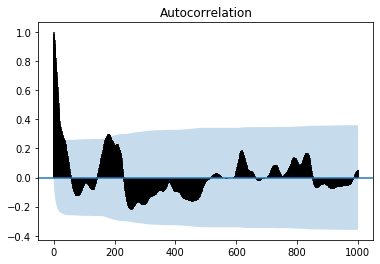

In [216]:
var, jb =BarReturnsPlot(sp)
plot_acf(var[20:].dropna(), lags=1000,alpha=0.05,marker=None)

# Distributions of different interval measurements

In [217]:
def ReturnsDistr(A,every_nth_day,bar_plot=None):
    A = A.replace([np.inf, -np.inf], np.nan).dropna(axis=0,subset=['Open', 'Close'])
    returns = A['Close'][every_nth_day-1::every_nth_day].reset_index(drop=True)-A['Open'][0:-1:every_nth_day].reset_index(drop=True)
    returns = returns.replace([np.inf, -np.inf], np.nan).dropna(axis=0)    
    if bar_plot != None:
        if every_nth_day in bar_plot:
            plt.hist(returns, bins=200, density = True,color='black')
            plt.xlim([-1,1])
            x = np.linspace(-1, 1, 100)
            returns = returns.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
            mu = np.mean(returns) 
            std = np.std(returns)
            p = norm.pdf(x, mu, std)
            plt.plot(x, p, 'k', linewidth=2,color='red')
            plt.show()
    
    return returns,jarque_bera(returns), sc.stats.kurtosis(returns, fisher=False)

Here we're using minute data:

C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


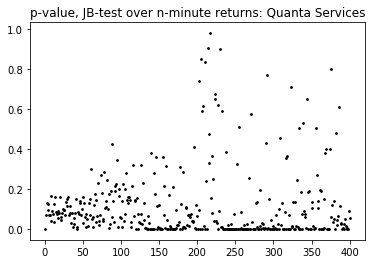

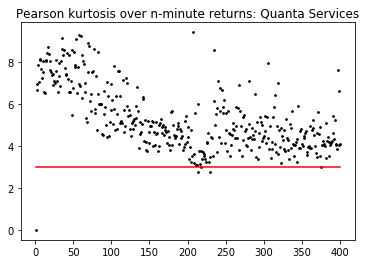

In [225]:
n = 421
m = 100
ticker = 'PWR'
stock = ticker +'.3'
p_val = np.zeros((n,2))
k_val = np.zeros(n)
lin = np.linspace(1,n,n)

Open = minute_data[ticker].iloc[3:]
Close = minute_data[stock].iloc[3:]

for i in range(3,len(Open)):
    Close.iloc[i-3] = pd.to_numeric(minute_data[stock].iloc[i])
    Open.iloc[i-3] = pd.to_numeric(minute_data[ticker].iloc[i])
open_close = pd.concat([Open,Close],axis=1).rename(columns={stock: "Close", ticker: "Open"})


for i in range(1,n):
    #Tak into account amount of datapoints! i*x, where x is amount of datapoints per QQ
    l = len(open_close.replace([np.inf, -np.inf], np.nan).dropna(axis=0,subset=['Open', 'Close']))
    j = 1
    p_val_list = list()
    k_val_list = list()
    while m*i*j < l:
        ret,p, k = ReturnsDistr(open_close[m*i*(j-1):m*i*j],i,bar_plot=[-1])
        p_val_list.append(p[1])
        k_val_list.append(k)
        j += 1
    p_val[i] = np.mean(p_val_list)
    k_val[i] = np.mean(k_val_list)
    if i in [-1]:
        qqplot(ret[1:], line='s',ms=3,color='black')
        #plt.title = str(i)+' minute changes'
        plt.show()
limit = 400
plt.scatter(lin[:limit],p_val[:limit,0],s=3,color='black')
#coefs = poly.polyfit(lin[:limit], p_val[:limit,0], deg=1)
#ffit = poly.polyval(lin[:limit], coefs)
#plt.plot(lin[:limit], ffit,label='Normal kurtosis = 3,'r')
plt.title('p-value, JB-test over n-minute returns: Quanta Services')
plt.show()
plt.scatter(lin[:limit],k_val[:limit],s=3,color='black')
plt.plot(lin[:limit], np.ones(limit)*3,label='Pearson normal kurtosis = 3',color='r')
plt.title('Pearson kurtosis over n-minute returns: Quanta Services')
plt.show()

Here S&P 500 data is used:

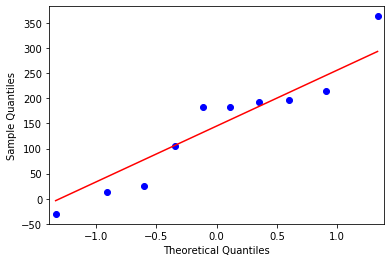

In [62]:
#Adjust size op your data to compare the effect of length of time periods, 
#i.e. JB from ReturnsDistr(sp[0:100],1) and ReturnsDistr(sp[0:1000],10) are comparable 
ret,jb=ReturnsDistr(sp[0:1500],150)
plotty = qqplot(ret,line='s')

# Realized volatility 

In [230]:
def DayRealVol(df,n,ticker, grouped):
    if grouped == False:
        dated = df[3:].reset_index(drop=True)
        for i,elt in enumerate(dated['Unnamed: 0']):
            dated['Unnamed: 0'].iloc[i] = datetime.strptime(elt, '%Y-%m-%d %H:%M:%S')
        dated = dated.set_index('Unnamed: 0')
        DFList = [group[1] for group in dated.groupby(dated.index.date)]
        md = DFList[n]
    if grouped == True:
        md = df[n]
    string = ticker + '.3'
    md = md[string]
    #Processing data
    md = md.dropna().reset_index(drop=True).iloc[1:]
    for i in range(len(md)):
        md.iloc[i] = pd.to_numeric(md.iloc[i])
    returns = md.shift(-1).iloc[:-1]/md.iloc[:-1]
    #for i, elt in enumerate(returns):
    #    returns.iloc[i] = elt
    #Start those calculationssss
    RealVol = 0
    for elt in returns:
        RealVol += m.log(elt)**2
    return RealVol

This thing will save you a LOT of time (~10 minutes --> ~2 seconds) by grouping by day in advance (instead of with every iteration), ONLY thing you should do it press run for this part (assuming you've already clicked download of the minute_data in the second box of this notebook):

In [231]:
lin = np.linspace(1,113,113)
DRV = np.zeros(113)
df = minute_data
dated = df[3:].reset_index(drop=True)
for i,elt in enumerate(dated['Unnamed: 0']):
    dated['Unnamed: 0'].iloc[i] = datetime.strptime(elt, '%Y-%m-%d %H:%M:%S')
dated = dated.set_index('Unnamed: 0')
DFList = [group[1] for group in dated.groupby(dated.index.date)]
print('Grouped!')

Grouped!


If you have used the previous grouping function (you're gonna be happy now), because you can simple insert DFList and put True for the 'grouped' variable. If you haven't insert minute_data instead and set 'grouped' to False

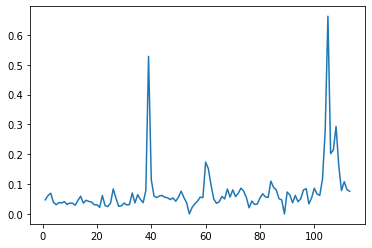

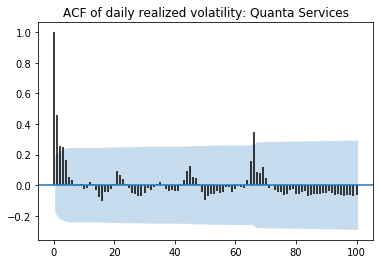

In [243]:
for i, elt in enumerate(lin):
    DRV[i] = DayRealVol(DFList,i,'PWR',True)*365
plt.plot(lin,DRV)
graphy = plot_acf(DRV, lags=100, alpha=0.05,marker=None, title = 'ACF of daily realized volatility: Quanta Services')

This is really cool, when looking at autocorrelation of liquid stock (e.g AAPL, MSFT, etc.) it is veryyy well within the 95% bounds, but when looking at less wel analysed stocks, the autocorrelation often exceeds these bounds! (days mainly consist of 390 minutes, the peaks that sometimes appear at multiples of these values are the correlation between daily 'overnight price changes'. Perhaps this can be explained by the fact that this is data from a bull-market? Also notice that the auto-correlation throughout all the data is positive. Which suggests positive terms for the ARCH model (as expected).
When splitting S&P 500 into 3 groups; large, mid and small, we get interesting results. 

-Small: Almost all of the auto-correlation can be found in the the last hour worth of data, lags<=60. I believe that due to lower liquidity i.e. lower trading frequency and lower market efficiency, it takes more time to adjust to the 'starting price of the day'.

-Mid: There is extremely high auto-correlation throughout the entire day's worth of data, lags<=390. I believe this is because most investors assess these stocks with a lower frequency which give a more continuous daily movement.

-Large: Auto-correlation is very low, but there is extreme auto-correlation inbetween 'overnight price changes'. This is due to extremely high liquidity i.e. high trading frequency and high market efficiency in these assets. It therefore shouldn't take more than a minute for most trading systems to settle on a fair 'starting price of the day'.

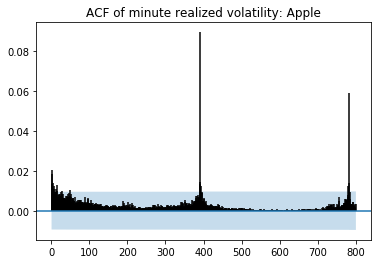

In [250]:
md = minute_data['AAPL.3'].iloc[3:]
for i in range(len(md)):
        md.iloc[i] = pd.to_numeric(md.iloc[i])
returns = md.shift(-1).iloc[:-1]/md.iloc[:-1]
MRV = np.zeros(len(returns))
for i, elt in enumerate(returns):
    MRV[i] = 390*m.log(elt)**2
MRV = MRV[np.logical_not(np.isnan(MRV))]
#Setting it equal due to a little problem in the function itself, it doesn't mean anything
graphy = plot_acf(MRV, zero= False,alpha=0.05, lags = 800,marker=None, title = 'ACF of minute realized volatility: Apple')

Daily ACF plot of this high-frequency data: